## Zillow Analysis

Reading our cleaned dataset, via src/process_zillow.py...

In [12]:
import pandas as pd

df = pd.read_parquet("../data/processed/zillow_rent_cleaned.parquet")

In [13]:
df.isna().sum()

zpid                    0
zestimate            2643
rentZestimate           0
latitude                0
longitude               0
bedrooms             2194
bathrooms            1808
livingArea           1805
yearBuilt            2789
lotSize              3532
homeType                0
homeStatus              0
miles_to_old_well       0
dtype: int64

In [14]:
df.shape

(25182, 13)

From the two cells above, we know that our "cleaned" data has quite a few missing pieces. 

Namely, out of the 22,763 total listings...
- 2642 have a missing zestimate
- 2194 have missing bedroom values
- 1808 have missing bathroom values
- 1805 have missing livingArea values
- 2789 have missing yearBuilt values
- 3532 have missing lotSize values

I think the best course of action as we continue to clean our data is to drop zestimate, yearBuilt, livingArrea, and lotSize as features in our dataset. This technical tradeoff allows us to retain the majority of our current dataset. Let's also drop homeType and homeStatus since they won't play a big part of our analysis.

Next, we'll drop all rows which have a missing bedrooms or bathrooms value. These are imperative to training our model!

In [15]:
import pandas as pd

# Load the original cleaned Zillow dataset (includes rentZestimate)
df = pd.read_parquet("../data/processed/zillow_rent_cleaned.parquet")

# Drop columns no longer needed for rent modeling
df = df.drop(columns=[
    "zestimate",
    "yearBuilt",
    "lotSize",
    "homeType",
    "homeStatus"
])

# Drop rows missing key features for rent prediction
df = df.dropna(subset=["rentZestimate", "bedrooms", "bathrooms", "livingArea"])

# Optional: drop listings with 0 bedrooms (to avoid divide-by-zero)
df = df[df["bedrooms"] > 0]

# Save the final cleaned dataset for rent modeling
output_path = "../data/processed/zillow_minimal_rent_cleaned.parquet"
df.to_parquet(output_path)

print(f"✅ Rent-focused cleaned dataset saved to: {output_path}")
print(f"Remaining rows: {len(df)}")

# Show remaining missing values (should be 0 or very low)
print(df.isna().sum())

✅ Rent-focused cleaned dataset saved to: ../data/processed/zillow_minimal_rent_cleaned.parquet
Remaining rows: 22494
zpid                 0
rentZestimate        0
latitude             0
longitude            0
bedrooms             0
bathrooms            0
livingArea           0
miles_to_old_well    0
dtype: int64


Great! Now we have 22,494 listings with no missing data woohoo. All set now. Time to get to work...

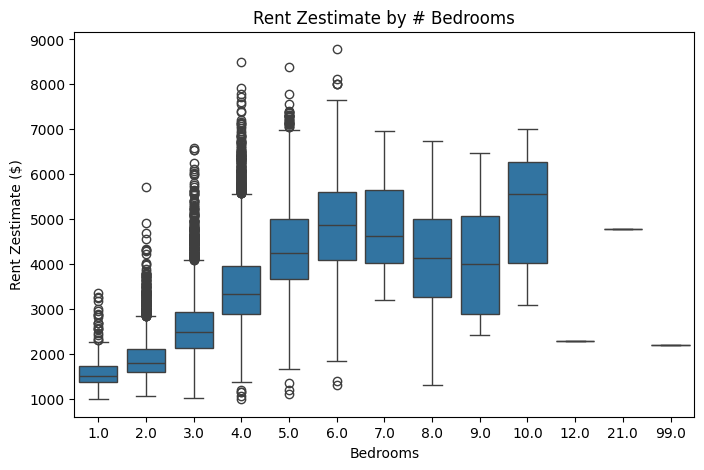

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Box‑plot of rent by bedroom count
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='bedrooms', y='rentZestimate')
plt.title("Rent Zestimate by # Bedrooms")
plt.ylabel("Rent Zestimate ($)")
plt.xlabel("Bedrooms")
plt.show()

In [17]:
%pip install shapely geopandas contextily


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


             count    mean
ppb_cluster               
0.0           5310   821.0
1.0           3768   856.0
2.0           2502  1432.0
3.0           4682   863.0
4.0           6232   833.0


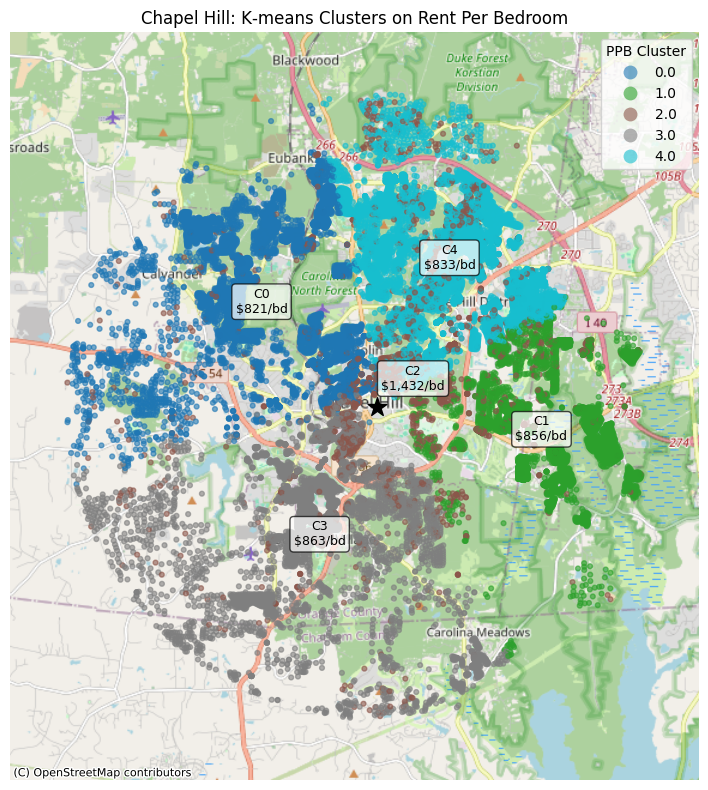

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from shapely.geometry import Point

df['ppb'] = df['rentZestimate'] / df['bedrooms']
features = df[['latitude','longitude','ppb']].dropna()
idx = features.index

# 3. Scale & cluster
scaler = StandardScaler()
X = scaler.fit_transform(features)

k = 5
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(X)
df.loc[idx, 'ppb_cluster'] = labels.astype(int)

# 4. Compute cluster stats
cluster_stats = (
    df.dropna(subset=['ppb_cluster','ppb'])
      .groupby('ppb_cluster')['ppb']
      .agg(count='count', mean='mean')
      .round(0)
)
print(cluster_stats)

# 5. Build GeoDataFrame of listings
gdf = gpd.GeoDataFrame(
    df.dropna(subset=['ppb_cluster']),
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 6. Centroids for annotation
centroids = scaler.inverse_transform(km.cluster_centers_)
centroid_gdf = gpd.GeoDataFrame(
    {
      'cluster': cluster_stats.index,
      'mean_ppb': cluster_stats['mean']
    },
    geometry=gpd.points_from_xy(centroids[:,1], centroids[:,0]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 7. Plot
fig, ax = plt.subplots(figsize=(10,8))

# listings colored by ppb cluster
gdf.plot(
    ax=ax, column='ppb_cluster', categorical=True,
    markersize=12, alpha=0.6, legend=True,
    legend_kwds={'title':'PPB Cluster'}
)

# annotate centroids with avg price/bedroom
for _, row in centroid_gdf.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y,
        f"C{int(row.cluster)}\n${int(row.mean_ppb):,}/bd",
        ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3",
                  facecolor="white", alpha=0.7)
    )

# mark Old Well
oldwell = gpd.GeoSeries(
    [Point(-79.0512301, 35.9120729)],
    crs="EPSG:4326"
).to_crs(epsg=3857)
oldwell.plot(ax=ax, marker='*', color='black',
             markersize=200, label='Old Well')

# zoom to data bounds
minx, miny, maxx, maxy = gdf.total_bounds
pad_x, pad_y = (maxx-minx)*0.1, (maxy-miny)*0.1
ax.set_xlim(minx-pad_x, maxx+pad_x)
ax.set_ylim(miny-pad_y, maxy+pad_y)

# add OSM basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
ax.set_title("Chapel Hill: K‑means Clusters on Rent Per Bedroom")
plt.tight_layout()
plt.show()

The map reveals five clear “price‐bands” around Chapel Hill, with the central campus/downtown cluster having the highest average rent per bedroom. 

This is an examples of the distance‐decay pattern: rents drop progressively as you move away from the Old Well. 